In [1]:
from GP_recovery import *

2022-11-09 12:59:39.491685: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2022-11-09 12:59:39.523916: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2022-11-09 12:59:39.525233: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/jul

0.26336135786308595
0.29757809812482694
0.3202066230161938
0.3281255832
0.3202066230161938
0.29757809812482694
0.26336135786308595


In [2]:
Nr = 1
t = np.linspace(0, 700, 701)
gp = GaussianProcess(kernel, t)
y = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))
y = y[0,:]
t.shape, y.shape

((701,), (701,))

In [3]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    # nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    # "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

Initial negative log likelihood: -1007.2208452431912
Gradient of the negative log likelihood, wrt the parameters:
{'log_Q': DeviceArray(-173.80210192, dtype=float64)}


### Performance

### Q

In [4]:
def solve():
    w_init = jnp.zeros(len(theta_init))
    lower_bounds = jnp.ones_like(w_init)* (-1)
    upper_bounds = jnp.ones_like(w_init) * jnp.inf
    bounds = (lower_bounds, upper_bounds)

    import jaxopt
    solver = jaxopt.ScipyBoundedMinimize(fun=neg_log_likelihood)
    soln = solver.run(theta_init, bounds=bounds, X=t, y=y)
    print(f"Final negative log likelihood: {soln.state.fun_val}")

    for key, value in soln.params.items():
        print(key[4:], np.exp(value))
    
    model_gp, _ = build_gp(soln.params, t)
    
    fig = plt.figure(figsize=(16, 6))
    plt.plot(t, kernel(t, t[:1]), lw=1, color='k', alpha=0.8, label='true kernel')
    plt.plot(t, model_gp.kernel(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
    plt.title('Kernels')
    plt.xlabel(r'$\Delta t$ [minutes]')
    plt.ylabel(r'Covariance [m$^2$/s$^2$]')
    plt.legend()
    plt.show()

Final negative log likelihood: -1077.3793105745785
Q 411.085628105124


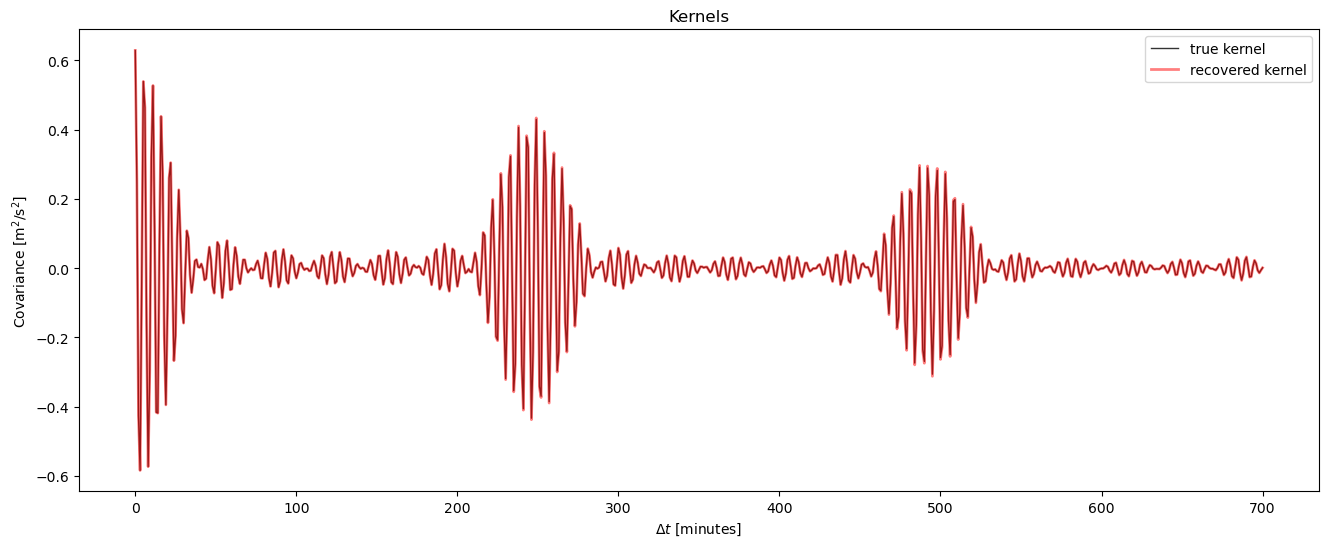

In [5]:
 solve()

### Q, delta_nu

In [6]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    # nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    # "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

Initial negative log likelihood: -1004.8570149082357
Gradient of the negative log likelihood, wrt the parameters:
{'log_Q': DeviceArray(-168.94012903, dtype=float64), 'log_delta_nu': DeviceArray(118.08088721, dtype=float64)}


### Q, nu_max

Initial negative log likelihood: -885.5416490647797
Gradient of the negative log likelihood, wrt the parameters:
{'log_Q': DeviceArray(-26.82330104, dtype=float64), 'log_nu_max': DeviceArray(-9843.83119739, dtype=float64)}
Final negative log likelihood: -1077.3813872241194
Q 411.05431407040675
nu_max 3080.702708158807


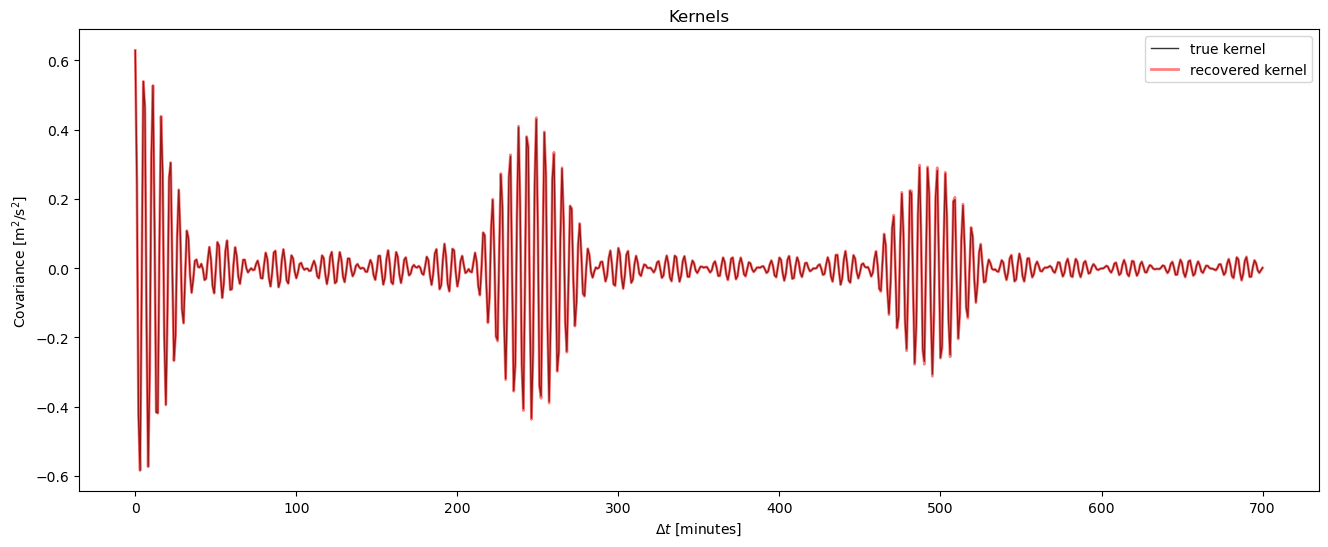

In [7]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A

Initial negative log likelihood: -402.9035692650816
Gradient of the negative log likelihood, wrt the parameters:
{'log_A': DeviceArray(-1881.69162911, dtype=float64), 'log_Q': DeviceArray(897.80398721, dtype=float64), 'log_nu_max': DeviceArray(-41869.81120253, dtype=float64)}
Final negative log likelihood: -1077.3704030491563
A 0.3678794411714424
Q 516.5902234708506
nu_max 3080.6772175751507


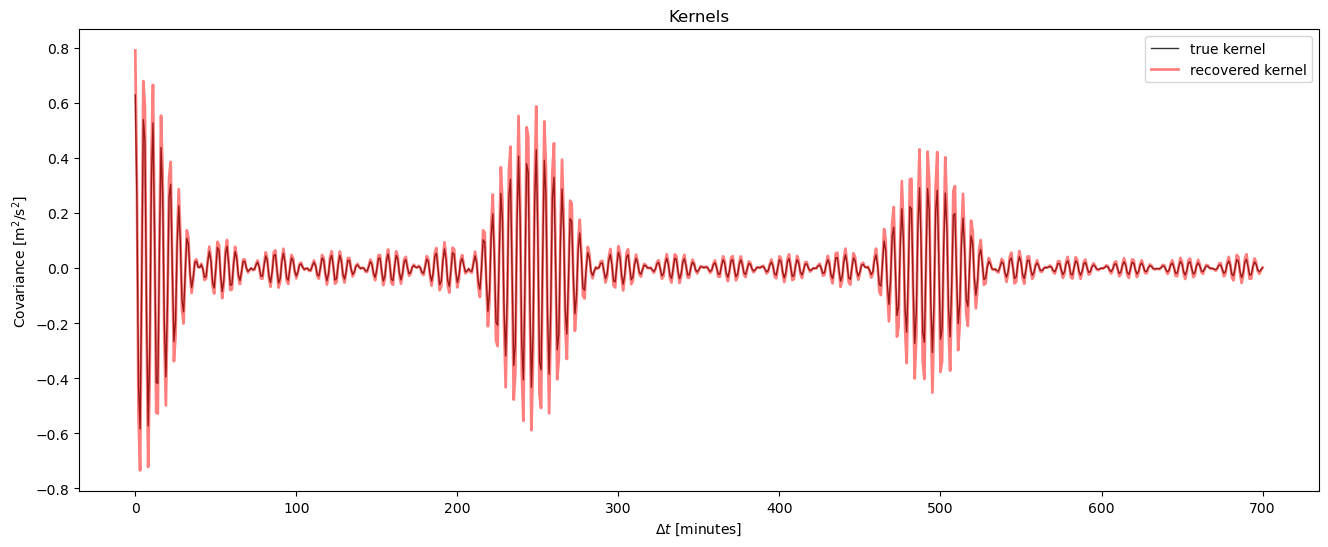

In [8]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

In [9]:
amp

0.3281255832

### Q, nu_max, A, delta_nu

Initial negative log likelihood: -449.806532120841
Gradient of the negative log likelihood, wrt the parameters:
{'log_A': DeviceArray(-1792.34464536, dtype=float64), 'log_Q': DeviceArray(851.73723983, dtype=float64), 'log_delta_nu': DeviceArray(-1319.75161876, dtype=float64), 'log_nu_max': DeviceArray(-41001.95551194, dtype=float64)}
Final negative log likelihood: -1077.840655186698
A 0.3678794411714424
Q 518.3873195587042
delta_nu 133.3774919737948
nu_max 3081.0144044590784


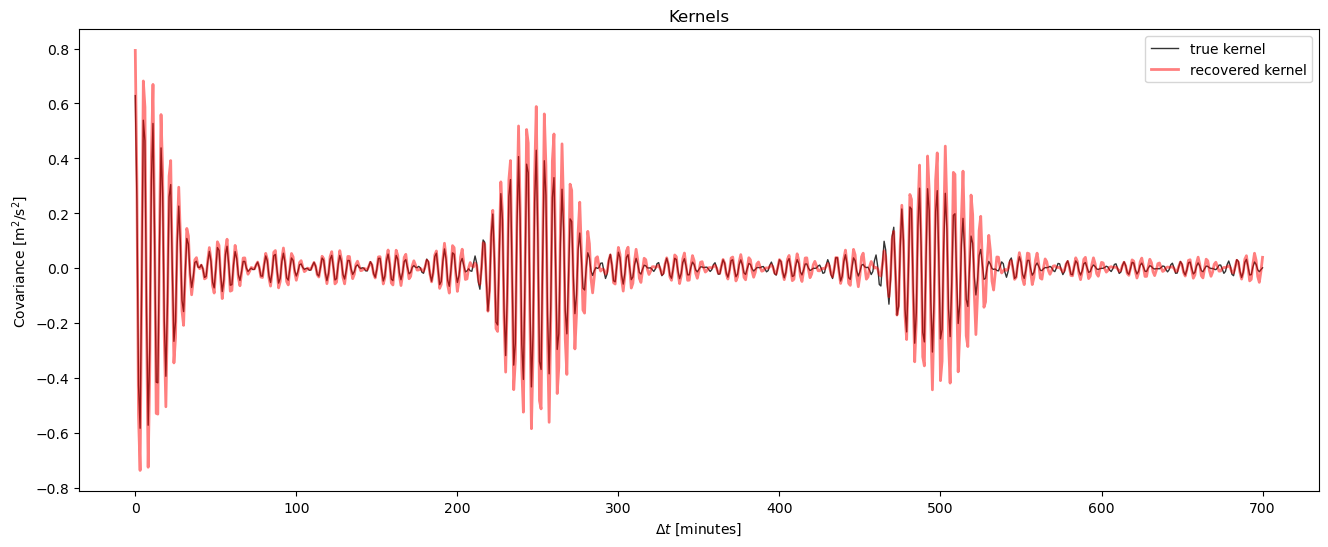

In [10]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A, delta_nu, W

Initial negative log likelihood: -441.51129368880447
Gradient of the negative log likelihood, wrt the parameters:
{'log_A': DeviceArray(-1813.73394852, dtype=float64), 'log_Q': DeviceArray(862.08481997, dtype=float64), 'log_W': DeviceArray(-477.81613515, dtype=float64), 'log_delta_nu': DeviceArray(-1317.11512448, dtype=float64), 'log_nu_max': DeviceArray(-41366.91654997, dtype=float64)}
Final negative log likelihood: -1078.0884655343307
A 0.37096110832792345
Q 472.7675047340585
W 237.02045863071214
delta_nu 133.55408237403827
nu_max 3081.133684383088


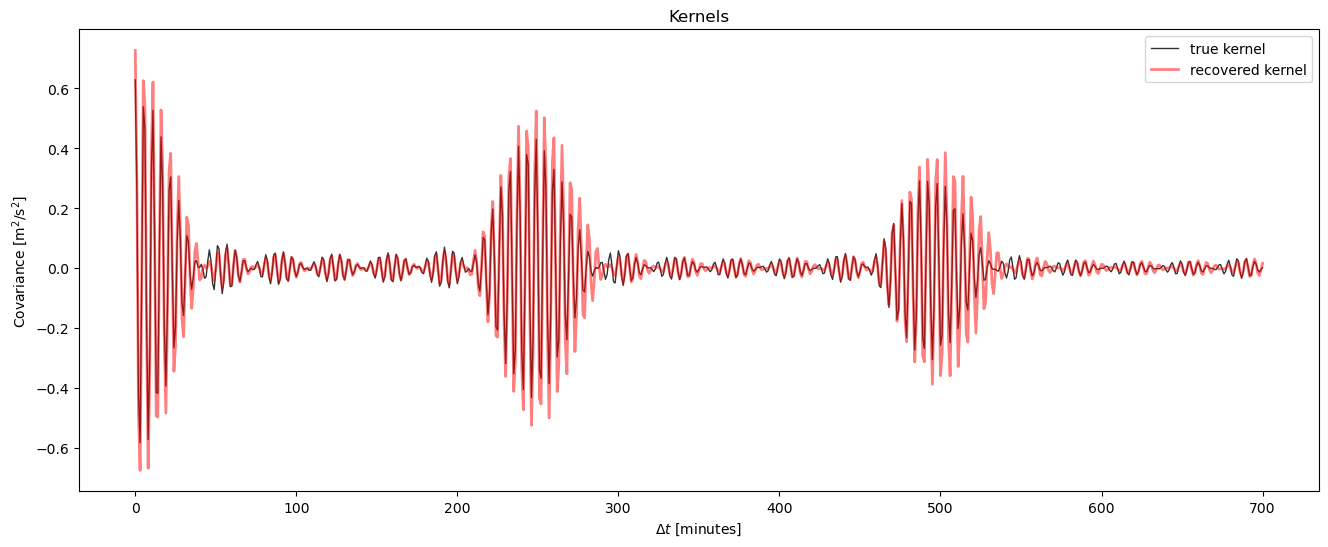

In [11]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

Initial negative log likelihood: -441.51129368880447
Gradient of the negative log likelihood, wrt the parameters:
{'epsilon': DeviceArray(-11.9877394, dtype=float64), 'log_A': DeviceArray(-1813.73394852, dtype=float64), 'log_Q': DeviceArray(862.08481997, dtype=float64), 'log_W': DeviceArray(-477.81613515, dtype=float64), 'log_delta_nu': DeviceArray(-1317.11512448, dtype=float64), 'log_nu_max': DeviceArray(-41366.91654997, dtype=float64)}
Final negative log likelihood: -1078.0884656008152
lon 1.0001760208832151
A 0.3709646856227132
Q 472.8016713562955
W 237.04100430572703
delta_nu 133.5537768521377
nu_max 3081.1331633904315


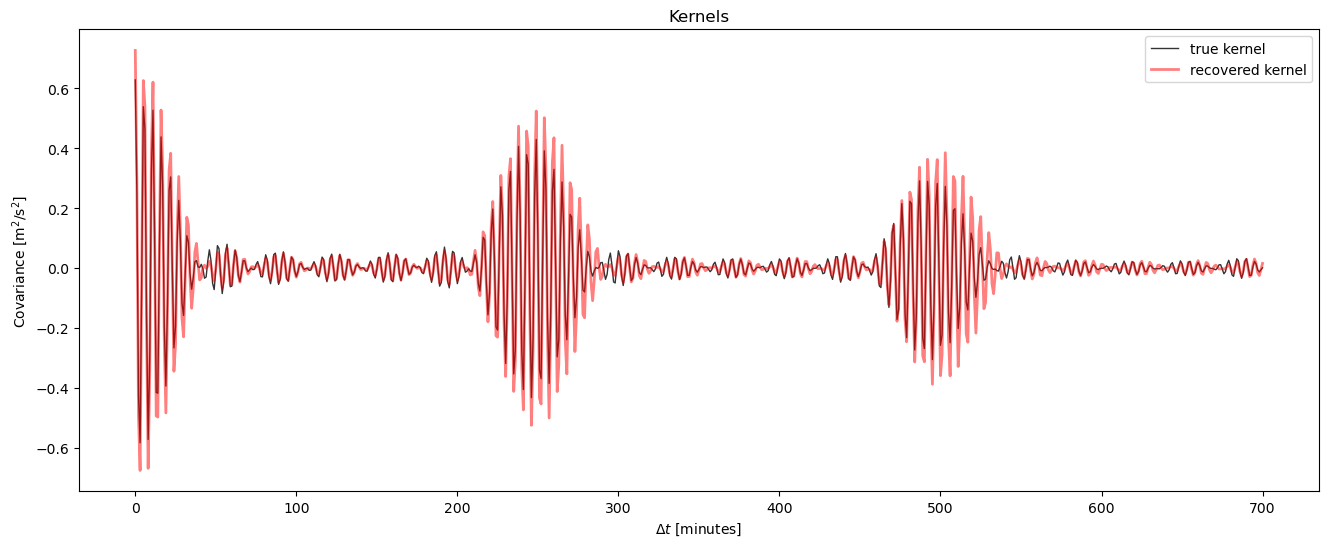

In [12]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])
    epsilon = theta["epsilon"]

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### +diag

Initial negative log likelihood: 599.2463496121363
Gradient of the negative log likelihood, wrt the parameters:
{'epsilon': DeviceArray(-2.19079363, dtype=float64), 'log_A': DeviceArray(-104.52758409, dtype=float64), 'log_Q': DeviceArray(30.38684337, dtype=float64), 'log_W': DeviceArray(-15.33899602, dtype=float64), 'log_delta_nu': DeviceArray(-3.92926598, dtype=float64), 'log_diag': DeviceArray(242.4420831, dtype=float64), 'log_nu_max': DeviceArray(-6821.82963315, dtype=float64)}
Final negative log likelihood: 421.67003288930715
lon 1.0998779723472647
A 0.3678794411714424
Q 334.39804228767065
W 1190.343787017255
delta_nu 133.9062946866547
diag 0.3678794411714424
nu_max 3144.378147750694


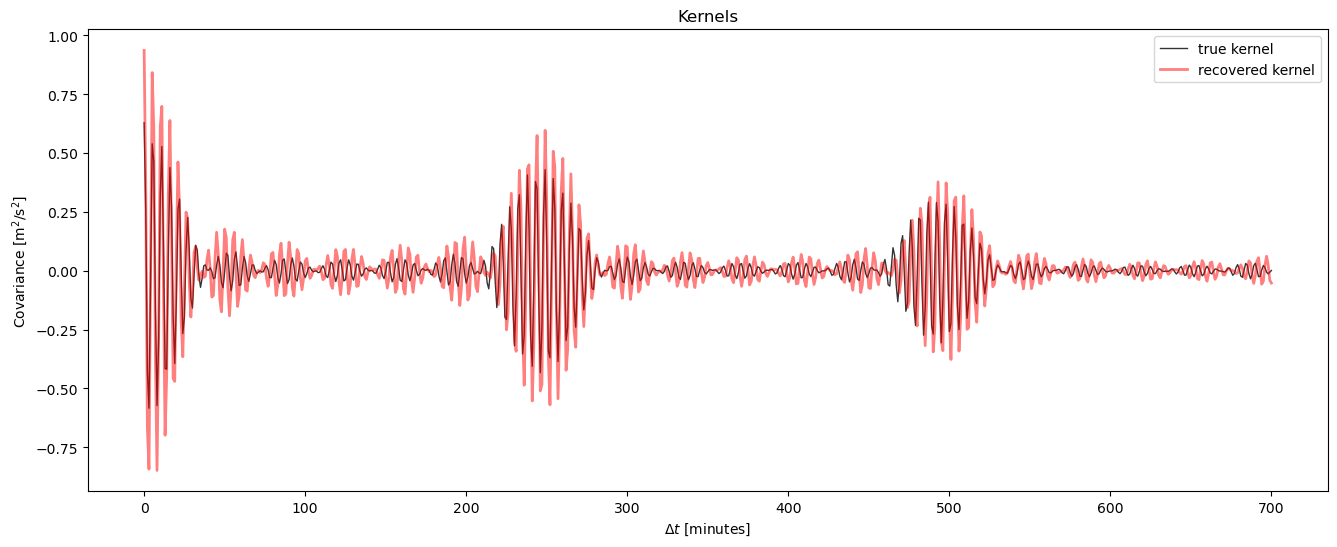

In [13]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])
    epsilon = theta["epsilon"]

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"])), kernel           

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()